In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Quality Start (QS) and Really Bad Start (RBS) metrics to quantify goalie performance were developed by Rob Bollman of the Hockey Abstract. Bollman defines a QS as a situation in which a starting goalie's ultimate game save percentage meets or exceeds the overall season mean save percentage. Hence, the bar for earning a QS changes from season to season and QS results can only be finalized after a regular season conclusion. On the other hand, Bollman defined a constant threshold of a less than 85% game save percentage to assign a starting goalie an RBS. Note that QS + RBS != total Games Started (GS) because of the usual gap between 85% and the season mean percentage.

This time, I am interested in looking at the influence of goalie age (known henceforth as Age) and "wear-and-tear" on RBS measurements in particular from season to season. We will evaluate season RBS:GS ratios (also to be known as $\textrm{RBS}\%$), noting that higher ratios reflect more negatively on goalies. In this simpler exercise, I will set the season RBS:GS ratio as a response/dependent/endogenous/target/etc. variable (more accurately, I will probably use a log-odds model with $\textrm{RBS}\% / (1 - \textrm{RBS}\%)$ as the response. I will use Age as an explanatory/independent/exogenous/feature/etc. variable. I generally hypothesize that as Age increases, the season RBS:GS ratio will also increase.

Cumulative NHL minutes and seasons played up to each NHL season would also likely be good explanatory variables. However, they will not figure in this exploration because they were not recorded in columns of this goalie data table from [Hockey Reference](https://hockey.reference.com). The total minutes and seasons data can be drawn from individual player pages on Hockey Reference, but exporting the individual goalie tables one-by-one or writing a script to do so will be left for another time. Since hockey players tend to start training fairly young at similar ages and there are few late starters due to the difficulty of learning to skate, I regard age as a good barometer for wear-and-tear. NHL season and minute totals also do not capture time spent playing in minor and youth leagues; some players need more time in the minors before being called up to The Show.

In [2]:
df_g = pd.read_csv('nhl_dataset/goalie_stats.csv', encoding = 'utf-8')
df_g.set_index(['Player_ID'])
df_g.tail(10)

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,...,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct
6640,2022,REG,vanecvi01,Vitek Vanecek,False,26,WSH,Washington Capitals,False,False,...,99.0,0.88,0,0.0,0.0,0.0,20.0,5.0,15.0,75.0
6641,2022,REG,varlasi01,Semyon Varlamov,False,33,NYI,New York Islanders,False,False,...,95.0,4.65,0,0.0,0.0,0.0,19.0,3.0,16.0,84.2
6642,2022,REG,vasilan02,Andrei Vasilevskiy,False,27,TBL,Tampa Bay Lightning,False,False,...,90.0,17.72,0,1.0,1.0,6.0,15.0,7.0,8.0,53.3
6643,2022,REG,vejmeka01,Karel Vejmelka,False,25,ARI,Arizona Coyotes,False,False,...,110.0,-14.78,0,0.0,0.0,0.0,3.0,2.0,1.0,33.3
6644,2022,REG,vladada01,Daniel Vladar,False,24,CGY,Calgary Flames,False,False,...,101.0,-0.46,0,1.0,1.0,0.0,5.0,1.0,4.0,80.0
6645,2022,REG,wedgesc01,Scott Wedgewood,False,29,TOT,Total,False,True,...,97.0,3.27,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6646,2022,REG,wedgesc01,Scott Wedgewood,False,29,ARI,Arizona Coyotes,True,False,...,96.0,3.65,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6647,2022,REG,wedgesc01,Scott Wedgewood,False,29,DAL,Dallas Stars,True,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6648,2022,REG,wedgesc01,Scott Wedgewood,False,29,NJD,New Jersey Devils,True,False,...,NaN,NaN,0,0.0,0.0,0.0,18.0,6.0,12.0,66.7
6649,2022,REG,wolljo01,Joseph Woll,False,23,TOR,Toronto Maple Leafs,False,False,...,NaN,NaN,0,0.0,0.0,2.0,NaN,NaN,NaN,NaN


Goalie QS and RBS statistics were consistently recorded starting in the 2007 - 2008 season, so we filter for data starting that season. Also, the hockey meta begins shifting more toward a heavier speed and skill emphasis after this point. 

In [3]:
df_g_2008 = df_g[df_g['Season'] >= 2008]
df_g_2008.tail(20)

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,...,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct
6630,2022,REG,sparkga01,Garret Sparks,False,28,LAK,Los Angeles Kings,False,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6631,2022,REG,staloal01,Alex Stalock,False,34,SJS,San Jose Sharks,False,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6632,2022,REG,stolaan01,Anthony Stolarz,False,28,ANA,Anaheim Ducks,False,False,...,89.0,8.24,0,1.0,1.0,2.0,4.0,2.0,2.0,50.0
6633,2022,REG,subbama01,Malcolm Subban,False,28,BUF,Buffalo Sabres,False,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6634,2022,REG,swaymje01,Jeremy Swayman,False,23,BOS,Boston Bruins,False,False,...,93.0,7.32,0,0.0,0.0,6.0,15.0,5.0,10.0,66.7
6635,2022,REG,talboca01,Cam Talbot,False,34,MIN,Minnesota Wild,False,False,...,95.0,6.38,0,1.0,1.0,2.0,15.0,4.0,11.0,73.3
6636,2022,REG,tarasda02,Daniil Tarasov,False,22,CBJ,Columbus Blue Jackets,False,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6637,2022,REG,thomplo01,Logan Thompson,False,24,VEG,Vegas Golden Knights,False,False,...,93.0,3.92,0,0.0,0.0,0.0,17.0,3.0,14.0,82.4
6638,2022,REG,tokardu01,Dustin Tokarski,False,32,BUF,Buffalo Sabres,False,False,...,109.0,-7.30,0,0.0,0.0,0.0,6.0,3.0,3.0,50.0
6639,2022,REG,ullmali01,Linus Ullmark,False,28,BOS,Boston Bruins,False,False,...,90.0,10.83,0,1.0,1.0,4.0,3.0,0.0,3.0,100.0


We select for qualifying goalies passing a threshold of starting at least 1000 minutes per season to filter out fluke metrics from players with less playing time.

In [4]:
df_g_2008_qual = df_g_2008[df_g_2008['MIN'] >= 1000].copy(deep = True)
df_g_2008_qual.tail()

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,...,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct
6642,2022,REG,vasilan02,Andrei Vasilevskiy,False,27,TBL,Tampa Bay Lightning,False,False,...,90.0,17.72,0,1.0,1.0,6.0,15.0,7.0,8.0,53.3
6643,2022,REG,vejmeka01,Karel Vejmelka,False,25,ARI,Arizona Coyotes,False,False,...,110.0,-14.78,0,0.0,0.0,0.0,3.0,2.0,1.0,33.3
6644,2022,REG,vladada01,Daniel Vladar,False,24,CGY,Calgary Flames,False,False,...,101.0,-0.46,0,1.0,1.0,0.0,5.0,1.0,4.0,80.0
6645,2022,REG,wedgesc01,Scott Wedgewood,False,29,TOT,Total,False,True,...,97.0,3.27,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6646,2022,REG,wedgesc01,Scott Wedgewood,False,29,ARI,Arizona Coyotes,True,False,...,96.0,3.65,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


We create a column keeping track of season RBS-to-GS ratios per player.

In [5]:
df_g_2008_qual['RBS_GS_ratio'] = df_g_2008_qual['RBS'] / df_g_2008_qual['GS']

In [6]:
df_g_2008_qual['RBS_GS_ratio'].isnull()

3574    False
3575    False
3577    False
3580    False
3582    False
        ...  
6642    False
6643    False
6644    False
6645    False
6646    False
Name: RBS_GS_ratio, Length: 906, dtype: bool

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
df_g_2008_qual.sort_values(by = 'RBS_GS_ratio', ascending = False)

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,Pos1,GP,GS,W,L,TOSL,GA,SA,SV,SV_Pct,GAA,SO,GPS,MIN,QS,QS_Pct,RBS,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct,RBS_GS_ratio
4158,2014,REG,ellisda01,Dan Ellis,False,33,TOT,Total,False,True,G,20,16.0,5.0,11.0,0.0,62,514.0,452.0,0.879,3.62,1,1.0,1027.0,4.0,0.250,6.0,140.0,-17.71,0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.375000
3693,2009,REG,garonma01,Mathieu Garon,False,31,TOT,Total,False,True,G,19,16.0,8.0,9.0,0.0,53,502.0,449.0,0.894,3.12,0,2.2,1021.0,7.0,0.438,6.0,115.0,-7.06,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.375000
4092,2013,REG,kiprumi01,Miikka Kiprusoff,False,36,CGY,Calgary Flames,False,False,G,24,24.0,8.0,14.0,2.0,77,650.0,573.0,0.882,3.44,0,1.6,1344.0,10.0,0.417,9.0,134.0,-19.75,0,1.0,1.0,0.0,7.0,3.0,4.0,57.1,0.375000
4281,2015,REG,fasthvi01,Viktor Fasth,False,32,EDM,Edmonton Oilers,False,False,G,26,24.0,6.0,15.0,3.0,76,681.0,605.0,0.888,3.41,0,1.9,1336.0,9.0,0.375,9.0,131.0,-17.87,0,0.0,0.0,0.0,24.0,4.0,20.0,83.3,0.375000
4857,2020,REG,subbama01,Malcolm Subban,False,26,VEG,Vegas Golden Knights,True,False,G,20,19.0,9.0,7.0,3.0,60,546.0,486.0,0.890,3.18,0,1.9,1133.0,7.0,0.368,7.0,122.0,-10.63,0,0.0,0.0,0.0,3.0,1.0,2.0,66.7,0.368421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4244,2014,REG,talboca01,Cam Talbot,False,26,NYR,New York Rangers,False,False,G,21,19.0,12.0,6.0,1.0,33,560.0,527.0,0.941,1.64,3,5.2,1211.0,16.0,0.842,0.0,68.0,15.25,0,0.0,0.0,0.0,3.0,1.0,2.0,66.7,0.000000
4933,2021,REG,nedelal01,Alex Nedeljkovic,False,25,CAR,Carolina Hurricanes,False,False,G,23,23.0,15.0,5.0,3.0,44,648.0,604.0,0.932,1.90,3,5.5,1392.0,15.0,0.652,0.0,74.0,15.70,0,1.0,1.0,2.0,3.0,0.0,3.0,100.0,0.000000
3930,2011,REG,montoal01,Al Montoya,False,25,NYI,New York Islanders,False,False,G,20,18.0,9.0,5.0,5.0,46,585.0,539.0,0.921,2.39,1,4.1,1154.0,13.0,0.722,0.0,90.0,4.96,0,1.0,1.0,2.0,9.0,3.0,6.0,66.7,0.000000
3968,2012,REG,budajpe01,Peter Budaj,False,29,MTL,Montreal Canadiens,False,False,G,17,17.0,5.0,7.0,5.0,44,508.0,464.0,0.913,2.55,0,3.1,1037.0,8.0,0.471,0.0,100.0,-0.08,0,3.0,3.0,2.0,15.0,7.0,8.0,53.3,0.000000


We need to account for goalies traded or waived during the regular season that played on multiple teams. These goalies are redundantly listed per season with individual teams capturing their team statistics and under the team label `"TOT"`, which captures their entire season statistics.

In [9]:
df_g_2008_qual[df_g_2008_qual.Team_ID == 'TOT']

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,Pos1,GP,GS,W,L,TOSL,GA,SA,SV,SV_Pct,GAA,SO,GPS,MIN,QS,QS_Pct,RBS,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct,RBS_GS_ratio
3574,2008,REG,auldal01,Alex Auld,False,27,TOT,Total,False,True,G,32,28.0,12.0,13.0,5.0,77,827.0,750.0,0.907,2.68,3,4.9,1722.0,12.0,0.429,6.0,102.0,-1.87,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.214286
3583,2008,REG,bryzgil01,Ilya Bryzgalov,False,27,TOT,Total,False,True,G,64,62.0,28.0,25.0,6.0,147,1829.0,1682.0,0.920,2.44,3,13.5,3614.0,37.0,0.597,5.0,88.0,19.15,0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,0.080645
3610,2008,REG,holmqjo01,Johan Holmqvist,False,29,TOT,Total,False,True,G,47,47.0,21.0,16.0,6.0,129,1164.0,1035.0,0.889,3.04,2,4.5,2549.0,19.0,0.404,17.0,122.0,-23.26,0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.361702
3614,2008,REG,huetcr01,Cristobal Huet,False,32,TOT,Total,False,True,G,52,51.0,32.0,14.0,6.0,118,1479.0,1361.0,0.920,2.32,4,11.1,3049.0,31.0,0.608,6.0,88.0,16.36,0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,0.117647
3653,2008,REG,smithmi01,Mike Smith,False,25,TOT,Total,False,True,G,34,32.0,15.0,19.0,0.0,84,848.0,764.0,0.901,2.59,3,4.4,1946.0,14.0,0.438,8.0,109.0,-6.97,0,1.0,1.0,12.0,NaN,NaN,NaN,NaN,0.250000
3693,2009,REG,garonma01,Mathieu Garon,False,31,TOT,Total,False,True,G,19,16.0,8.0,9.0,0.0,53,502.0,449.0,0.894,3.12,0,2.2,1021.0,7.0,0.438,6.0,115.0,-7.06,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.375000
3696,2009,REG,gerbema01,Martin Gerber,False,34,TOT,Total,False,True,G,26,26.0,10.0,14.0,1.0,78,799.0,721.0,0.902,3.03,1,4.2,1545.0,13.0,0.500,5.0,107.0,-4.88,0,1.0,1.0,16.0,NaN,NaN,NaN,NaN,0.192308
3714,2009,REG,labarja01,Jason LaBarbera,False,29,TOT,Total,False,True,G,28,24.0,8.0,10.0,6.0,67,674.0,607.0,0.901,2.78,2,3.4,1446.0,13.0,0.542,7.0,109.0,-5.32,0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,0.291667
3754,2009,REG,tellqmi01,Mikael Tellqvist,False,29,TOT,Total,False,True,G,21,16.0,9.0,6.0,1.0,47,533.0,486.0,0.912,2.74,0,3.4,1028.0,9.0,0.563,2.0,96.0,1.77,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.125000
3768,2010,REG,auldal01,Alex Auld,False,29,TOT,Total,False,True,G,24,20.0,9.0,7.0,3.0,64,610.0,546.0,0.895,2.96,0,2.5,1300.0,8.0,0.400,4.0,118.0,-9.87,0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,0.200000


If the same `Player_ID` shows up multiple times in a season, we use the row labeled with `Team_ID == "TOT"` and delete the other individual team listings. Since `"TOT"` `MIN` will always be greater or equal than the individual team `MIN` for a season, one approach for eliminating `Player_ID` season duplicates would be to filter for the row with the maximum `MIN` per `Season`. Another approach would be to eliminate the `Team_ID` strings that do not match `"TOT"`.

In [10]:
df_g_2008_qual_tot = df_g_2008_qual.sort_values('MIN', ascending = False).drop_duplicates(subset = ['Season', 'Player_ID']) #Drop duplicates of `Player_ID` if they exist by lower `MIN` in a `Season`, which should correspond to `Team_ID` == "TOT".

In [11]:
df_g_2008_qual_tot.shape #We check the size of our filtered DataFrame. The number of rows appears reasonable for the number of seasons the DataFrame spans and goals in the league.

(822, 38)

In [12]:
df_g_2008_qual_tot.nsmallest(n = 20, columns = 'RBS_GS_ratio')

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,Pos1,GP,GS,W,L,TOSL,GA,SA,SV,SV_Pct,GAA,SO,GPS,MIN,QS,QS_Pct,RBS,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct,RBS_GS_ratio
4963,2021,REG,vasilan02,Andrei Vasilevskiy,False,26,TBL,Tampa Bay Lightning,False,False,G,42,42.0,31.0,10.0,1.0,93,1237.0,1144.0,0.925,2.21,5,9.6,2524.0,24.0,0.571,0.0,82.0,20.96,0,4.0,4.0,0.0,3.0,1.0,2.0,66.7,0.000000
4133,2014,REG,anderfr01,Frederik Andersen,False,24,ANA,Anaheim Ducks,False,False,G,28,24.0,20.0,5.0,0.0,60,783.0,723.0,0.923,2.29,0,5.6,1569.0,12.0,0.500,0.0,89.0,7.47,0,1.0,1.0,0.0,4.0,0.0,4.0,100.0,0.000000
4933,2021,REG,nedelal01,Alex Nedeljkovic,False,25,CAR,Carolina Hurricanes,False,False,G,23,23.0,15.0,5.0,3.0,44,648.0,604.0,0.932,1.90,3,5.5,1392.0,15.0,0.652,0.0,74.0,15.70,0,1.0,1.0,2.0,3.0,0.0,3.0,100.0,0.000000
4244,2014,REG,talboca01,Cam Talbot,False,26,NYR,New York Rangers,False,False,G,21,19.0,12.0,6.0,1.0,33,560.0,527.0,0.941,1.64,3,5.2,1211.0,16.0,0.842,0.0,68.0,15.25,0,0.0,0.0,0.0,3.0,1.0,2.0,66.7,0.000000
3930,2011,REG,montoal01,Al Montoya,False,25,NYI,New York Islanders,False,False,G,20,18.0,9.0,5.0,5.0,46,585.0,539.0,0.921,2.39,1,4.1,1154.0,13.0,0.722,0.0,90.0,4.96,0,1.0,1.0,2.0,9.0,3.0,6.0,66.7,0.000000
4516,2017,REG,mcelhcu01,Curtis McElhinney,False,33,TOT,Total,False,True,G,21,15.0,8.0,8.0,2.0,51,616.0,565.0,0.917,2.70,1,3.9,1135.0,9.0,0.600,0.0,96.0,2.31,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000
4960,2021,REG,ullmali01,Linus Ullmark,False,27,BUF,Buffalo Sabres,False,False,G,20,20.0,9.0,6.0,3.0,49,591.0,542.0,0.917,2.63,0,4.1,1117.0,11.0,0.550,0.0,90.0,5.45,0,0.0,0.0,0.0,13.0,1.0,12.0,92.3,0.000000
3968,2012,REG,budajpe01,Peter Budaj,False,29,MTL,Montreal Canadiens,False,False,G,17,17.0,5.0,7.0,5.0,44,508.0,464.0,0.913,2.55,0,3.1,1037.0,8.0,0.471,0.0,100.0,-0.08,0,3.0,3.0,2.0,15.0,7.0,8.0,53.3,0.000000
4666,2019,REG,bishobe01,Ben Bishop,False,32,DAL,Dallas Stars,False,False,G,46,45.0,27.0,15.0,2.0,87,1323.0,1236.0,0.934,1.98,7,10.8,2637.0,31.0,0.689,1.0,73.0,32.24,0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,0.022222
4099,2013,REG,lundqhe01,Henrik Lundqvist,False,30,NYR,New York Rangers,False,False,G,43,43.0,24.0,16.0,3.0,88,1190.0,1102.0,0.926,2.05,2,9.3,2575.0,29.0,0.674,1.0,84.0,16.81,0,1.0,1.0,0.0,25.0,6.0,19.0,76.0,0.023256


In [13]:
df_g_2008_qual_tot.nsmallest(n = 20, columns = 'MIN')

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,Pos1,GP,GS,W,L,TOSL,GA,SA,SV,SV_Pct,GAA,SO,GPS,MIN,QS,QS_Pct,RBS,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct,RBS_GS_ratio
4257,2015,REG,backsni01,Niklas B‰ckstrˆm,False,36,MIN,Minnesota Wild,False,False,G,19,14.0,5.0,7.0,3.0,51,452.0,401.0,0.887,3.05,0,1.2,1005.0,2.0,0.143,4.0,132.0,-12.42,0,0.0,0.0,2.0,6.0,2.0,4.0,66.7,0.285714
6551,2022,REG,gillijo01,Jon Gillies,False,28,TOT,Total,False,True,G,20,15.0,3.0,10.0,2.0,62,550.0,488.0,0.887,3.70,0,1.9,1005.0,6.0,0.400,3.0,121.0,-10.85,0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.200000
4347,2015,REG,tokardu01,Dustin Tokarski,False,25,MTL,Montreal Canadiens,False,False,G,17,16.0,6.0,6.0,4.0,46,509.0,463.0,0.910,2.75,0,2.7,1005.0,8.0,0.500,1.0,106.0,-2.56,0,1.0,1.0,0.0,23.0,9.0,14.0,60.9,0.062500
4898,2021,REG,hillad01,Adin Hill,False,24,ARI,Arizona Coyotes,False,False,G,19,17.0,9.0,9.0,1.0,46,530.0,484.0,0.913,2.74,2,3.4,1006.0,8.0,0.471,2.0,94.0,2.83,0,0.0,0.0,0.0,5.0,2.0,3.0,60.0,0.117647
4645,2018,REG,rittida01,David Rittich,False,25,CGY,Calgary Flames,False,False,G,21,16.0,8.0,6.0,3.0,49,512.0,463.0,0.904,2.92,0,2.4,1008.0,10.0,0.625,3.0,109.0,-4.06,0,0.0,0.0,14.0,NaN,NaN,NaN,NaN,0.187500
4296,2015,REG,huttoca01,Carter Hutton,False,29,NSH,Nashville Predators,False,False,G,18,17.0,6.0,7.0,4.0,44,450.0,406.0,0.902,2.61,1,2.0,1010.0,6.0,0.353,3.0,115.0,-5.59,0,0.0,0.0,0.0,15.0,7.0,8.0,53.3,0.176471
4001,2012,REG,labarja01,Jason LaBarbera,False,32,PHX,Phoenix Coyotes,False,False,G,19,14.0,3.0,9.0,3.0,43,486.0,443.0,0.912,2.54,0,2.8,1015.0,8.0,0.571,1.0,102.0,-0.98,0,0.0,0.0,2.0,11.0,7.0,4.0,36.4,0.071429
3693,2009,REG,garonma01,Mathieu Garon,False,31,TOT,Total,False,True,G,19,16.0,8.0,9.0,0.0,53,502.0,449.0,0.894,3.12,0,2.2,1021.0,7.0,0.438,6.0,115.0,-7.06,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.375000
3827,2010,REG,mcelhcu01,Curtis McElhinney,False,26,TOT,Total,False,True,G,20,14.0,8.0,5.0,2.0,51,523.0,472.0,0.902,2.99,0,2.6,1023.0,6.0,0.429,1.0,110.0,-4.59,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.071429
6530,2022,REG,comrier01,Eric Comrie,False,26,WPG,Winnipeg Jets,False,False,G,19,16.0,10.0,5.0,1.0,44,550.0,506.0,0.920,2.58,1,3.7,1025.0,10.0,0.625,1.0,86.0,7.15,0,1.0,1.0,0.0,6.0,2.0,4.0,66.7,0.062500


# Exploratory data analysis

Let us look at the RBS:GS ratio distribution per season.

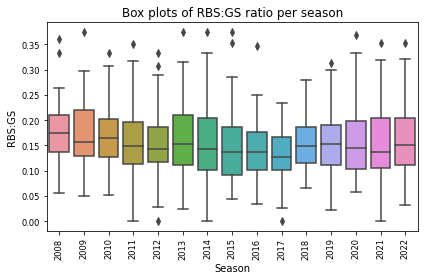

In [14]:
ax = sns.boxplot(data = df_g_2008_qual_tot, x = 'Season', y = 'RBS_GS_ratio')
ax.xaxis.set_tick_params(labelsize = 'small', labelrotation = 90)
ax.set_ylabel('RBS:GS')
ax.yaxis.set_tick_params(labelsize = 'small')
ax.set_title('Box plots of RBS:GS ratio per season')
plt.tight_layout()
plt.show()

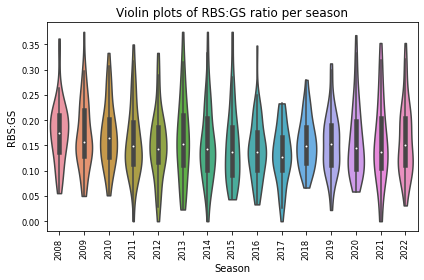

In [15]:
ax = sns.violinplot(data = df_g_2008_qual_tot, x = 'Season', y = 'RBS_GS_ratio', cut = 0.)
ax.xaxis.set_tick_params(labelsize = 'small', labelrotation = 90)
ax.set_ylabel('RBS:GS')
ax.yaxis.set_tick_params(labelsize = 'small')
ax.set_title('Violin plots of RBS:GS ratio per season')
plt.tight_layout()
plt.show()

Note that we have y-axis truncation at 0 specified with `cut = 0` in this violin plot as an artifact of Gaussian KDE estimation. As such, the box plot is probably more appropriate for visualization.

It looks like RBS:GS has remained relatively stable through all the seasons based on the box and violin plots. We also note the presence of a fairly consistent skew toward higher RBS:GS throughout the seasons, suggesting that teams frequently need to hold on to and play underperforming goalies because it is difficult to find a serviceable one. Also, I had a relatively lower qualifying threshold of 1000. Goalies who are doing poorly are probably yanked earlier and play fewer minutes. The skew would probably be reduced using a larger threshold of minutes.

We will run a smooth regression to observe if the mean RBS:GS curve remains fairly flat. We can do a LOWESS fit.

In [93]:
import statsmodels.api as sm
from scipy.stats import norm

In [94]:
smoothed_mean = sm.nonparametric.lowess(exog = df_g_2008_qual_tot['Season'], endog = df_g_2008_qual_tot['RBS_GS_ratio'], frac = 0.3)

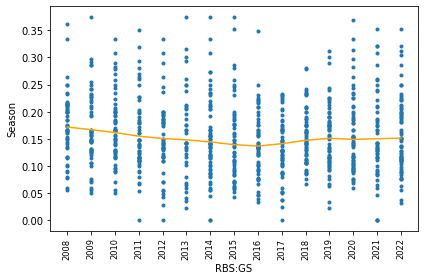

In [95]:
fig, ax = plt.subplots()
ax.scatter(df_g_2008_qual_tot['Season'], df_g_2008_qual_tot['RBS_GS_ratio'], marker = '.')
ax.plot(smoothed_mean[:, 0], smoothed_mean[:, 1], c = 'orange')
ax.xaxis.set_tick_params(labelsize = 'small', labelrotation = 90)
ax.set_xticks(np.arange(2008, 2023, 1))
ax.set_xlabel('RBS:GS')
ax.set_ylabel('Season')
plt.tight_layout()
plt.show()

Looks fairly flat! Now, let us also do a LOWESS fit with a bootstrapped confidence interval.

In [96]:
class lowess_rbs_gs_season_boot_ci():
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def lowess_with_CI(self, N = 500, alpha = 0.05, lowess_frac = 0.3):
        #Perform bootstrapping with replacement to allow re-sampling with more qualifying goalies than actual per season.
        df_boot_season = self.df.groupby('Season').sample(N, replace = True, random_state = 0)
        #Compute smoothed LOWESS mean from bootstrapped DataFrame.
        smoothed_mean = sm.nonparametric.lowess(exog = df_boot_season.Season, endog = df_boot_season.RBS_GS_ratio, frac = lowess_frac) #Requires statsmodels.api.
        unsmoothed_mean = df_boot_season.groupby('Season')['RBS_GS_ratio'].mean()
        unsmoothed_std = df_boot_season.groupby('Season')['RBS_GS_ratio'].std()
        z_score = norm.ppf(1 - alpha / 2) #Requires scipy.stats.
        lower = unsmoothed_mean + z_score * unsmoothed_std
        upper = unsmoothed_mean - z_score * unsmoothed_std
        return smoothed_mean, unsmoothed_mean, lower, upper, df_boot_season

In [97]:
boot_df_object = lowess_rbs_gs_season_boot_ci(df_g_2008_qual_tot)
boot_smoothed_mean, boot_unsmoothed_mean, boot_lower, boot_upper, df_boot_season = boot_df_object.lowess_with_CI()

In [98]:
df_boot_season.shape

(7500, 38)

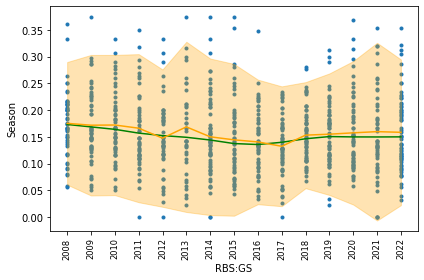

In [99]:
fig, ax = plt.subplots()
ax.scatter(df_g_2008_qual_tot['Season'], df_g_2008_qual_tot['RBS_GS_ratio'], marker = '.')
ax.plot(boot_smoothed_mean[:, 0], boot_smoothed_mean[:, 1], c = 'green')
ax.plot(boot_unsmoothed_mean.index, boot_unsmoothed_mean.values, c = 'orange')
ax.fill_between(boot_unsmoothed_mean.index, boot_lower.values, boot_upper.values, alpha = 0.3, color = 'orange')
ax.xaxis.set_tick_params(labelsize = 'small', labelrotation = 90)
ax.set_xticks(np.arange(2008, 2023, 1))
ax.set_xlabel('RBS:GS')
ax.set_ylabel('Season')
plt.tight_layout()
plt.show()

Under assumptions that $\textrm{RBS}\%$ is normally distributed every season, we note the presence of some outliers sitting outside the 95\% CI. Hence, for curiosity's sake, we will additionally test for assumptions of normality for a particular season even if Gaussian models are relatively robust to non-normality and some deviation from normality is fine. Let us look at the 2022 season, which based visually on the violin plot, does not look so Gaussian. Nonetheless, we will proceed with the null hypothesis that the 2022 season is normally distributed with an $\alpha = 0.05$.

In [103]:
from statsmodels.stats.diagnostic import lilliefors
lilliefors_2022_season_ks_stat_and_p_value = lilliefors(df_g_2008_qual_tot[df_g_2008_qual_tot['Season'] == 2022]['RBS_GS_ratio'])
lilliefors_2022_season_ks_stat_and_p_value[1]

0.07332022727199881

$0.07332022727199881 > 0.05$, so we actually fail to reject the null hypothesis and conclude that $\textrm{RBS}\%$ is not normally distributed. Next, we will also try a Shapiro-Wilk test on the same 2022 $\textrm{RBS}\%$ data with the same $\alpha$.

In [104]:
from scipy.stats import shapiro
shapiro_wilk_2022_season_w_stat_and_p_value = shapiro(df_g_2008_qual_tot[df_g_2008_qual_tot['Season'] == 2022]['RBS_GS_ratio'])
shapiro_w

0.0685645043849945

Again, 0.05 is exceeded, so we fail to reject the null hypothesis. For completionists' sake, we will print the Lilliefors and Shapiro-Wilk p-values for all of the since-2008 seasons in our scope.

In [123]:
lilliefors_p = []
shapiro_wilk_p = []
season = [i for i in range(2008, 2023)]

for i in season:
    lilliefors_2022_season_ks_stat_and_p_value = lilliefors(df_g_2008_qual_tot[df_g_2008_qual_tot['Season'] == i]['RBS_GS_ratio'])
    print(f'Lilliefors p-value for {i} season: {lilliefors_2022_season_ks_stat_and_p_value[1]}')
    lilliefors_p.append(lilliefors_2022_season_ks_stat_and_p_value[1])
    shapiro_wilk_2022_season_w_stat_and_p_value = shapiro(df_g_2008_qual_tot[df_g_2008_qual_tot['Season'] == i]['RBS_GS_ratio'])
    print(f'Shapiro-Wilk p-value for {i} season: {shapiro_wilk_2022_season_w_stat_and_p_value[1]}')
    shapiro_wilk_p.append(shapiro_wilk_2022_season_w_stat_and_p_value[1])
    
for iterable in enumerate(zip(season, lilliefors_p, shapiro_wilk_p)):
    season, lillie, shap = iterable[1] #Unpack values from non-index tuple element of iterator tuple.
    if lillie and shap <= 0.05:
        print(f'In {season}, both the Lilliefors and Shapiro-Wilk test agree to reject the null hypothesis of normality.')
    elif lillie <= 0.05:
        print(f'In {season}, the Lilliefors test (but not Shapiro-Wilk) agrees to reject the null hypothesis of normality.')
    elif shap <= 0.05:
        print(f'In {season}, the Shapiro-Wilk test (but not Lilliefors) agrees to reject the null hypothesis of normality.')
    else:
        print(f'In {season}, neither Shapiro-Wilk nor Lilliefors rejects the null.')

Lilliefors p-value for 2008 season: 0.14043917074908693
Shapiro-Wilk p-value for 2008 season: 0.12960270047187805
Lilliefors p-value for 2009 season: 0.004149808667349243
Shapiro-Wilk p-value for 2009 season: 0.12969794869422913
Lilliefors p-value for 2010 season: 0.442616428252841
Shapiro-Wilk p-value for 2010 season: 0.32310616970062256
Lilliefors p-value for 2011 season: 0.02737740810324342
Shapiro-Wilk p-value for 2011 season: 0.08489840477705002
Lilliefors p-value for 2012 season: 0.07321816722456347
Shapiro-Wilk p-value for 2012 season: 0.2820490002632141
Lilliefors p-value for 2013 season: 0.5137630581753498
Shapiro-Wilk p-value for 2013 season: 0.5650991201400757
Lilliefors p-value for 2014 season: 0.02855382836315898
Shapiro-Wilk p-value for 2014 season: 0.15298902988433838
Lilliefors p-value for 2015 season: 0.3535261622695405
Shapiro-Wilk p-value for 2015 season: 0.003532182890921831
Lilliefors p-value for 2016 season: 0.23125288751108175
Shapiro-Wilk p-value for 2016 season

The Lilliefors test appears is a little more sensitive, as the null is rejected for the Lilliefors more frequently than for the Shapiro-Wilk. The Shapiro-Wilk test only rejects the null in 2015 and 2020 and never rejects alone without agreement from the Lilliefors test.

Subsequently, let us plot the RBS:GS ratio for each `Player_ID` since 2008 with year as the x-axis to get a sense of whether an individual goalie's season-to-season $\textrm{RBS}\%$ follows some pattern as his career develops.

So, we do not presently have access to cumulative minutes or seasons played, but what about the influence of `Age` and the interaction between `Age` and season minutes on $\textrm{RBS}\%$? We move toward regression and inference with general linear models. Is there a correlation between Age or Age * Minute and $\textrm{RBS}\%$ that points to older players having trouble shouldering higher per-season minutes?